# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [2]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import pandas as pd

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Load the dataset from your Drive folder

train = loadmat('C:/Users/bncha/Downloads/train_32x32.mat')
test = loadmat('C:/Users/bncha/Downloads/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [6]:
train_images = train['X']
test_images = test['X']
train_labels = train['y']
test_labels = test['y']

train_images = train_images/255
test_images = test_images/255
train_labels = train_labels[:,0]
test_labels = test_labels[:,0]
scaled_train_images = train_images.transpose((3,0,1,2))
scaled_test_images = test_images.transpose((3,0,1,2))


print('scaled image sizes : ')
print('train images:' + str(scaled_train_images.shape))
print('test images:' + str(scaled_test_images.shape))

scaled image sizes : 
train images:(73257, 32, 32, 3)
test images:(26032, 32, 32, 3)


In [7]:
def plot_random_images(images,labels,rows,columns):

  num_train_images = images.shape[0]

  random_inx = np.random.choice(num_train_images, rows*columns)
  random_train_images = images[random_inx,...]
  random_train_labels = labels[random_inx, ...]





  fig, axes = plt.subplots(rows, columns,figsize = (16,16))
  fig.subplots_adjust(hspace=-0.7, wspace= 0.2)

  for i,ax in enumerate(axes.flat):

      ax.imshow(np.squeeze(random_train_images[i]))
      ax.text(6., -1.0, f'Digit {random_train_labels[i]}',fontsize = 20)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
            
      
  plt.show()




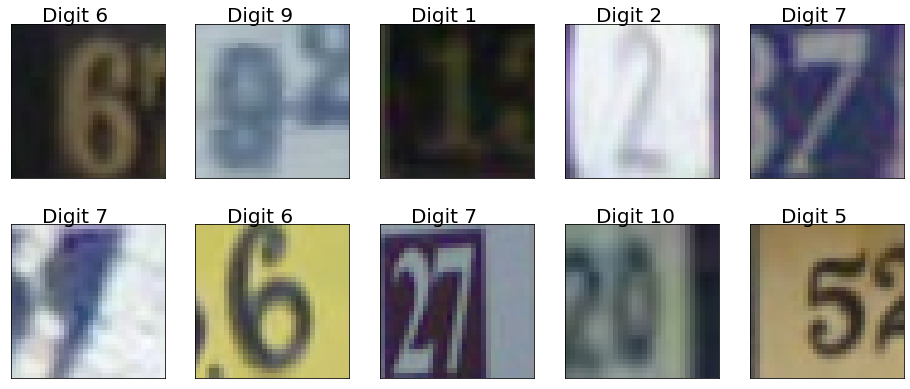

In [8]:
plot_random_images(scaled_train_images,train_labels,2,5)

In [11]:
grayscale_train_images = np.mean(scaled_train_images, axis= 3)
grayscale_train_images = grayscale_train_images[...,np.newaxis]

grayscale_test_images = np.mean(scaled_test_images, axis= 3)
grayscale_test_images = grayscale_test_images[...,np.newaxis]


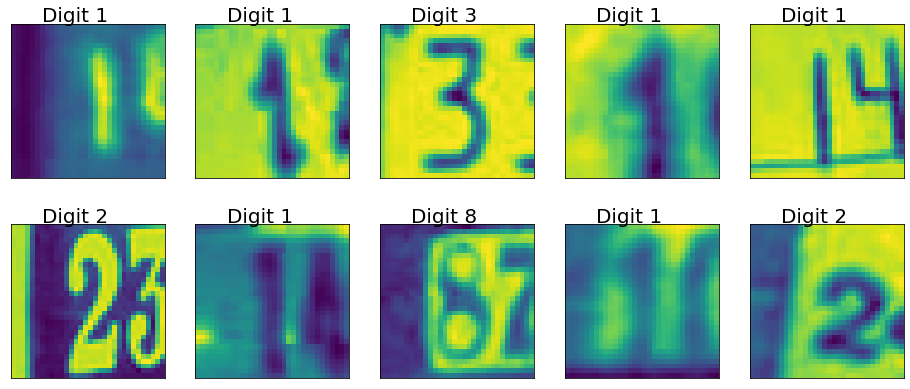

In [7]:
plot_random_images(grayscale_train_images,train_labels,2,5)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [8]:
def get_mlp_model(input_shape):

  model = Sequential([
                      Dense(64,activation = 'relu',input_shape = input_shape),
                      Dense(64,activation = 'relu'),
                      Flatten(),
                      Dense(128,activation = 'relu'),
                      Dense(128,activation = 'relu'),
                      Dense(11,activation = 'softmax')



  ])

  model.compile(
          optimizer = "adam",
          loss = "sparse_categorical_crossentropy",
          metrics = ['accuracy']
      )
  return model

In [9]:
model = get_mlp_model(grayscale_train_images[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32, 64)        128       
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 64)        4160      
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1419      
Total params: 8,410,955
Trainable params: 8,410,955
Non-trainable params: 0
______________________________________________

In [10]:
early_stopping = EarlyStopping(monitor = "val_accuracy",mode = "max",patience = 3)



checkpoint = ModelCheckpoint(filepath = '/content/checkpoint_mlp_best/checkpoint',save_freq = "epoch",save_weights_only = True,verbose = 1, save_best_only = True,monitor = "val_accuracy")

history = model.fit(grayscale_train_images,train_labels,
                    epochs = 10,
                    validation_split= 0.15,
                    callbacks=[early_stopping,checkpoint],
                    verbose = 1)

Epoch 1/10
1946/1946 [==============================] - ETA: 0s - loss: 1.6253 - accuracy: 0.4408
Epoch 00001: val_accuracy improved from -inf to 0.65784, saving model to /content/checkpoint_mlp_best\checkpoint
1946/1946 [==============================] - 233s 120ms/step - loss: 1.6253 - accuracy: 0.4408 - val_loss: 1.1043 - val_accuracy: 0.6578
Epoch 2/10
1946/1946 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.6870
Epoch 00002: val_accuracy improved from 0.65784 to 0.70907, saving model to /content/checkpoint_mlp_best\checkpoint
1946/1946 [==============================] - 244s 126ms/step - loss: 1.0069 - accuracy: 0.6870 - val_loss: 0.9389 - val_accuracy: 0.7091
Epoch 3/10
1946/1946 [==============================] - ETA: 0s - loss: 0.8827 - accuracy: 0.7282
Epoch 00003: val_accuracy improved from 0.70907 to 0.73164, saving model to /content/checkpoint_mlp_best\checkpoint
1946/1946 [==============================] - 254s 131ms/step - loss: 0.8827 - accuracy:

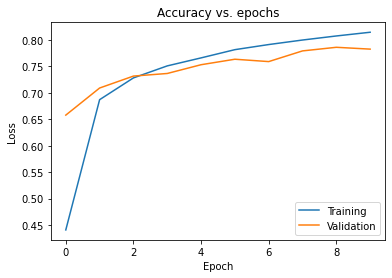

In [11]:

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

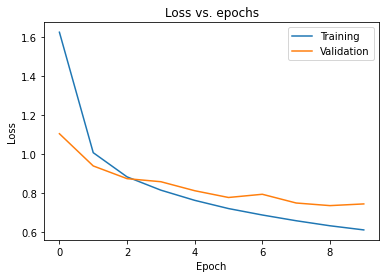

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [13]:
test_loss, test_accuracy = model.evaluate(grayscale_test_images, test_labels)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

814/814 [==============================] - 27s 33ms/step - loss: 0.9151 - accuracy: 0.7503
Test loss: 0.9151020050048828
Test accuracy: 0.7503457069396973


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [4]:
def get_cnn_model(input_shape):

  model = Sequential([
                          

          Conv2D(64,input_shape = input_shape,kernel_size = (3,3),activation = "relu",padding = 'SAME'),
          Conv2D(64,kernel_size = (3,3),activation = "relu",padding = 'SAME'),
          MaxPooling2D(pool_size = (2,2)),
          BatchNormalization(),
          Conv2D(128,kernel_size = (3,3),activation = "relu",padding = 'SAME'),
          MaxPooling2D(pool_size = (2,2)),
          Dropout(0.5),
          Flatten(),
          Dense(64,activation = "relu"),
          Dense(64,activation = "relu"),
          Dense(11,activation = "softmax")
  ])


  model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

  return model

In [12]:
cnn_model = get_cnn_model(grayscale_train_images[0].shape)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0

In [16]:
early_stopping = EarlyStopping(monitor = "val_accuracy",mode = "max",patience = 3)

checkpoint = ModelCheckpoint(filepath = '/content/checkpoint_cnn_best/checkpoint',save_freq = "epoch",save_weights_only = True,verbose = 1, save_best_only = True,monitor = "val_accuracy")


history = cnn_model.fit(grayscale_train_images,train_labels,epochs = 10,validation_split= 0.15,callbacks = [checkpoint,early_stopping])

Epoch 1/10
1946/1946 [==============================] - ETA: 0s - loss: 0.7535 - accuracy: 0.7612
Epoch 00001: val_accuracy improved from -inf to 0.86113, saving model to /content/checkpoint_cnn_best\checkpoint
1946/1946 [==============================] - 521s 268ms/step - loss: 0.7535 - accuracy: 0.7612 - val_loss: 0.4573 - val_accuracy: 0.8611
Epoch 2/10
1946/1946 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.8624
Epoch 00002: val_accuracy did not improve from 0.86113
1946/1946 [==============================] - 514s 264ms/step - loss: 0.4506 - accuracy: 0.8624 - val_loss: 0.4984 - val_accuracy: 0.8509
Epoch 3/10
1946/1946 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8786
Epoch 00003: val_accuracy improved from 0.86113 to 0.87606, saving model to /content/checkpoint_cnn_best\checkpoint
1946/1946 [==============================] - 554s 285ms/step - loss: 0.3974 - accuracy: 0.8786 - val_loss: 0.3995 - val_accuracy: 0.8761
Epoch 4/10


In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(grayscale_test_images, test_labels)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
model_best_epoch_file = tf.train.latest_checkpoint("checkpoint_mlp_best")
model = get_mlp_model(grayscale_train_images[0].shape)
model.load_weights(model_best_epoch_file)

test_loss, test_accuracy = model.evaluate(grayscale_test_images, test_labels)
print("MLP best weights model ")
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

In [13]:
model_best_epoch_file = tf.train.latest_checkpoint("checkpoint_cnn_best")
model = get_cnn_model(grayscale_train_images[0].shape)
model.load_weights(model_best_epoch_file)

test_loss, test_accuracy = model.evaluate(grayscale_test_images, test_labels)
print("CNN best weights model ")
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

814/814 [==============================] - 44s 54ms/step - loss: 0.3344 - accuracy: 0.9015
CNN best weights model 
Test loss: 0.3344075083732605
Test accuracy: 0.9015442728996277


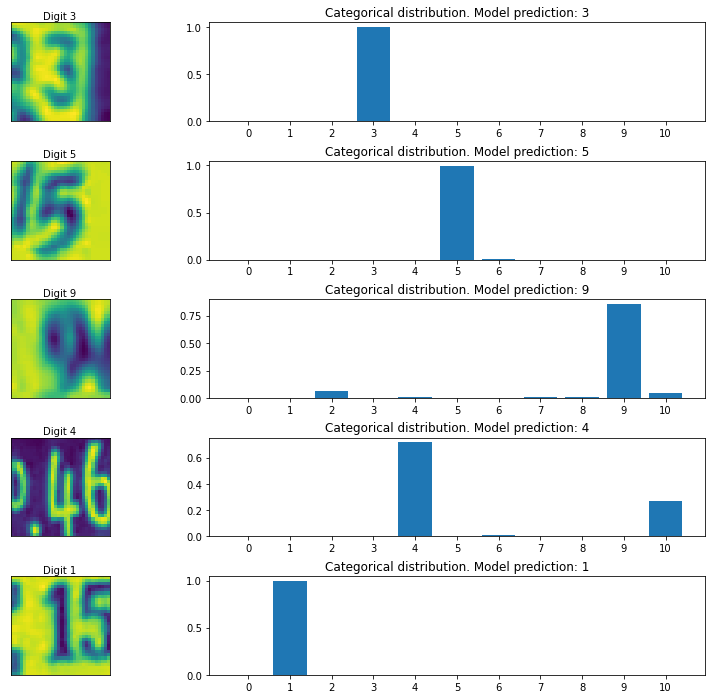

In [14]:
num_test_images = grayscale_test_images.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = grayscale_test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()

In [18]:
import cv2
import PIL
from PIL import Image, ImageEnhance, ImageDraw, ImageFont
from IPython.display import display

img = Image.open('no_3.png')

In [26]:

img = cv2.imread('no_0.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (32, 32))
my_img = img[np.newaxis,...,np.newaxis]

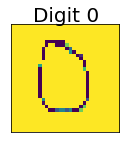

In [34]:
fig, axes = plt.subplots(1, 1,figsize = (2,2))
fig.subplots_adjust(hspace=-0.7, wspace= 0.2)
#for i,ax in enumerate(axes.flat):
 #   ax.imshow(np.squeeze(my_img))
  #  ax.text(6., -1.0, f'Digit {0}',fontsize = 20)
  #  ax.get_xaxis().set_visible(False)
   # ax.get_yaxis().set_visible(False)
axes.imshow(np.squeeze(my_img))
axes.text(6., -1.0, f'Digit {0}',fontsize = 20)
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)
    
plt.show()

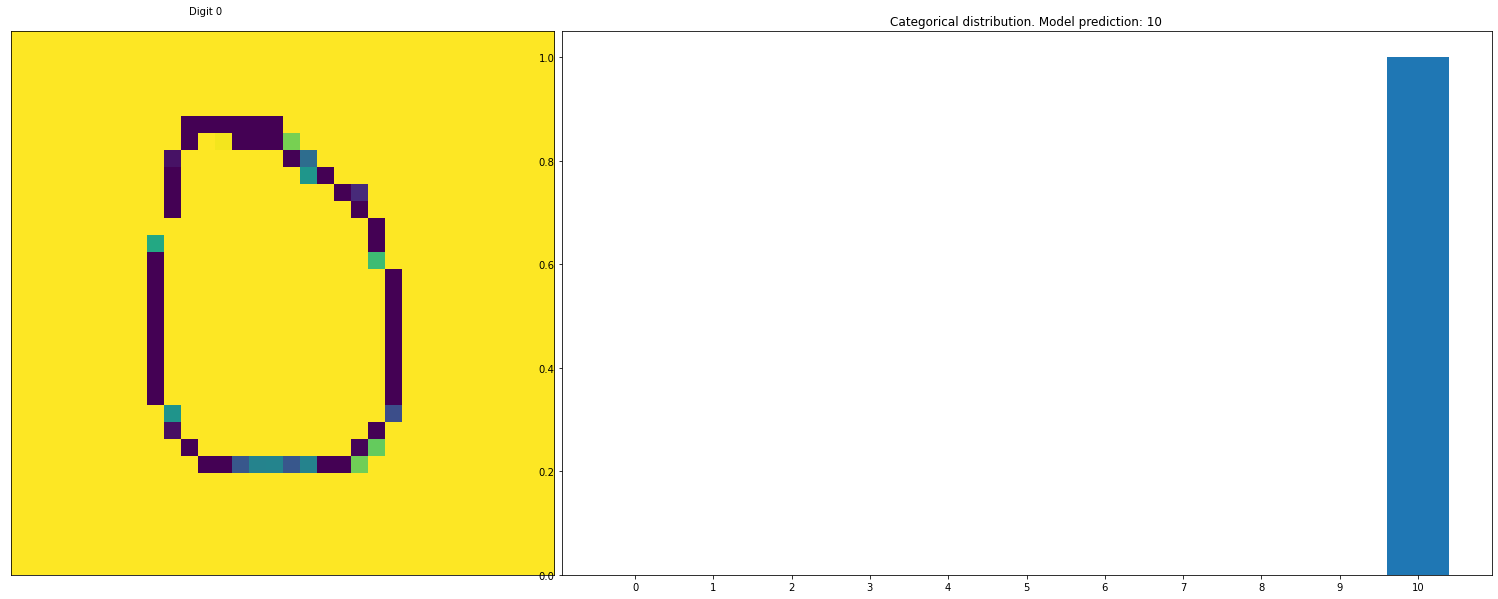

In [44]:

predict = model.predict(my_img)

fig, axes = plt.subplots(1,2, figsize=(25, 10))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

axes[0].imshow(np.squeeze(my_img))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].text(10., -1.5, f'Digit {0}')
for pred in predict:
  axes[1].bar(np.arange(len(pred)), pred)
  axes[1].set_xticks(np.arange(len(pred)))
  axes[1].set_title(f"Categorical distribution. Model prediction: {np.argmax(pred)}")